In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mean = [0.485, 0.456, 0.405]
std  = [0.229, 0.224, 0.225]

In [4]:
transforms = transforms.Compose([
                                transforms.Resize(300),
                                transforms.RandomResizedCrop(299),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [5]:
# https://www.kaggle.com/prasunroy/natural-images

data_dir = 'datasets/natural_images'

In [6]:
dataset = datasets.ImageFolder(root=data_dir,
                                  transform=transforms)

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 6899
    Root location: datasets/natural_images
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=bilinear)
               RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.405], std=[0.229, 0.224, 0.225])
           )

In [8]:
len(dataset)

6899

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

In [10]:
print(train_size)
print(test_size)

5519
1380


In [11]:
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [12]:
batch_size = 4

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True)

In [14]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=True)

In [15]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [16]:
total_batch_sizes = { 'train': len(train_loader), 'test': len(test_loader) }

In [17]:
total_batch_sizes

{'train': 1380, 'test': 345}

In [18]:
class_names = dataset.classes

print(class_names)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [19]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)

In [20]:
inputs, classes = next(iter(dataloaders['train']))

In [21]:
out = torchvision.utils.make_grid(inputs)

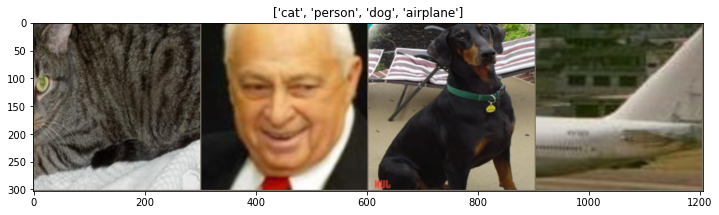

In [22]:
imshow(out, title=[class_names[x] for x in classes])

## Load DenseNet

In [23]:
from torchvision import models

model = models.densenet121(pretrained=True)

In [24]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
num_ftrs = model.classifier.in_features
num_ftrs

1024

In [26]:
# 8 classes
model.classifier = nn.Linear(num_ftrs, 8)

In [27]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [28]:
criterion        = nn.CrossEntropyLoss()

optimizer_ft     = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1)

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    model = model.to(device)
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / total_batch_sizes[phase]
            epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Training complete')
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [30]:
model = train_model(model, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


C:\Users\platon\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.3357 Acc: 0.8063
test Loss: 0.7374 Acc: 0.9391

Epoch 1/4
----------
train Loss: 1.5395 Acc: 0.8714
test Loss: 0.8618 Acc: 0.9333

Epoch 2/4
----------
train Loss: 1.2683 Acc: 0.8971
test Loss: 0.5218 Acc: 0.9601

Epoch 3/4
----------
train Loss: 0.9819 Acc: 0.9243
test Loss: 0.4760 Acc: 0.9601

Epoch 4/4
----------
train Loss: 0.7575 Acc: 0.9379
test Loss: 0.3281 Acc: 0.9710

Training complete
Best val Acc: 0.971014


In [31]:
# save the mdel with new learned parameters

torch.save(model.state_dict(),'models/model.pt')

In [32]:
model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
    
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the test images: 96.95652173913044%


Actual label 1


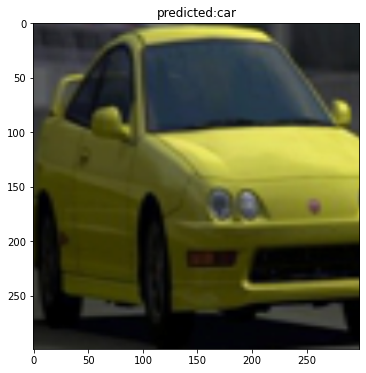

Actual label 1


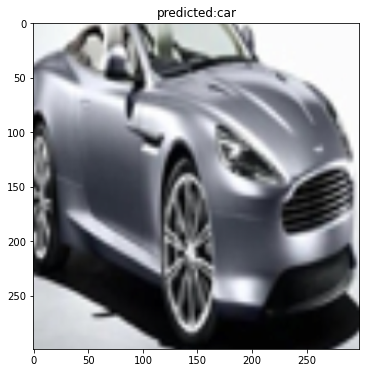

Actual label 3


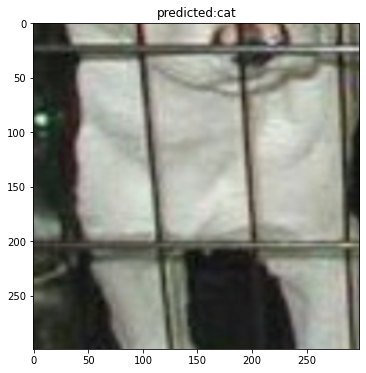

Actual label 1


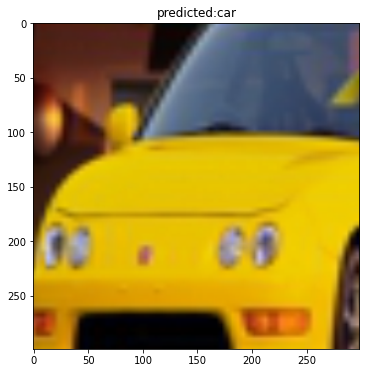

In [33]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    inputs = inputs.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        print ("Actual label", np.array(labels)[j])
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])